> OCR-한글텍스트

In [2]:
from PIL import Image
import pytesseract

image = Image.open('c:/vscode/data/images/kor_text2.png')
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
text = pytesseract.image_to_string(image, lang='kor')
print(text)

선 언 으 로 재 택 근 무 를 폐 지 하 고 완 전 한 사 무 실 근 무 체 제 로 돌 아 가 려 는
무 실 로 불 러 들 이 면 서 이 미 재 택 근 무 에 익 숙 해 진 칙입:이 반 발도 크 다 .

서 울 종 로 구 의 한 회 사 는 최 근 코 로 나 19 확 진 자 를 제 외 한 재 택 근 무 를 종 료 한 다 고 공 지 했 다 .

김 모 (29) 씨 는 " 직 장 이 멀 어 서 출 근 시 간 에 이 미 지 쳐 재 택 근 무 가 더 효 율 적 이 라 고 느 낄
때 가 있 었 다 " 며 " 이 제 완 전 히 코 로 나 19 이 전 문 화 로 돌 아 가 는 듯 해 아 쉽 다 " 고 말 했 다 .




> OCR-자동차번호판

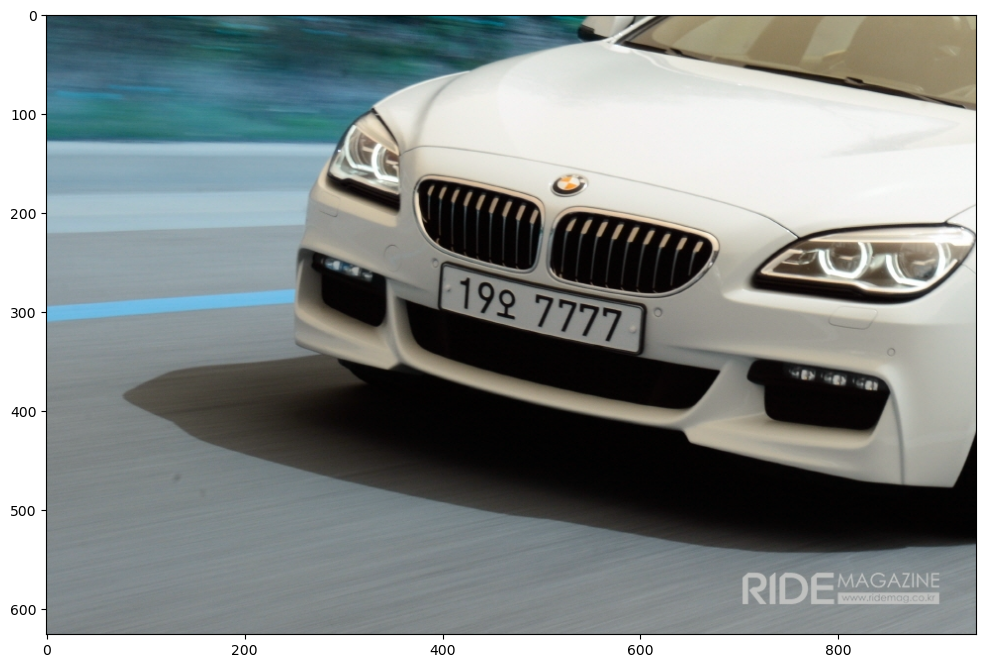

In [3]:
import cv2
import matplotlib.pyplot as plt
img_ori = cv2.imread('c:/vscode/data/images/car/car1.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car2.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car3.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car4.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car5.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car6.png')
#img_ori = cv2.imread('c:/vscode/data/images/car/car7.png')
height, width, channel = img_ori.shape
plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')
plt.show()

19오7777
19오7777


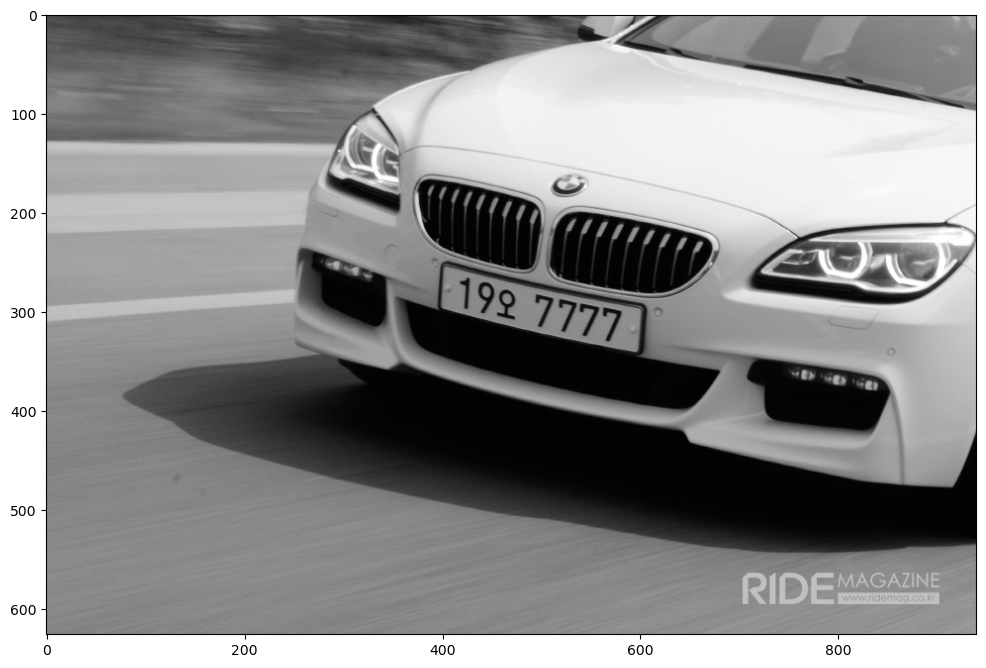

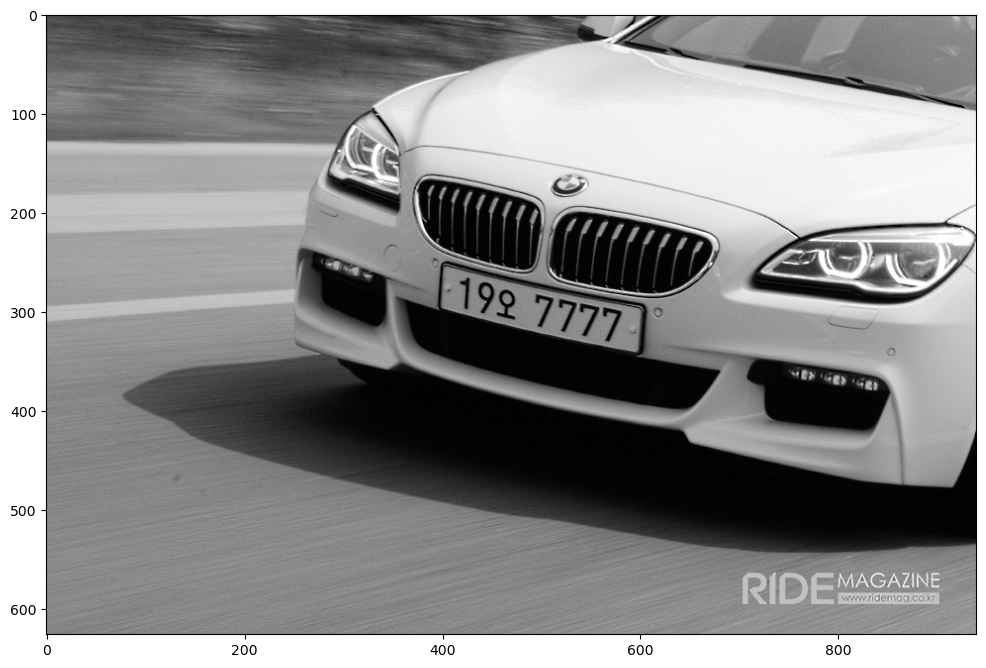

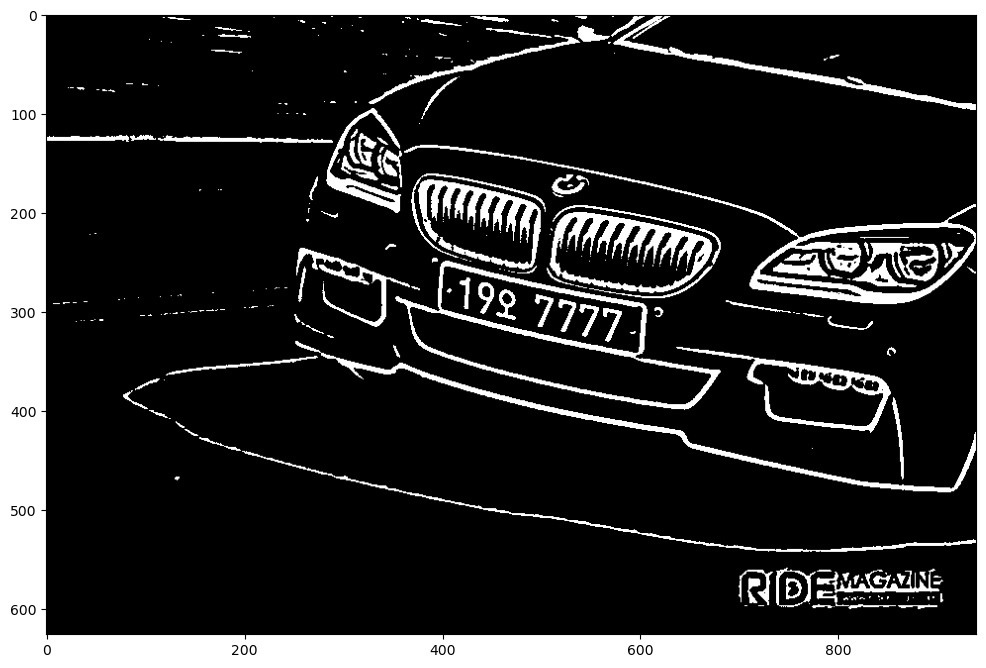

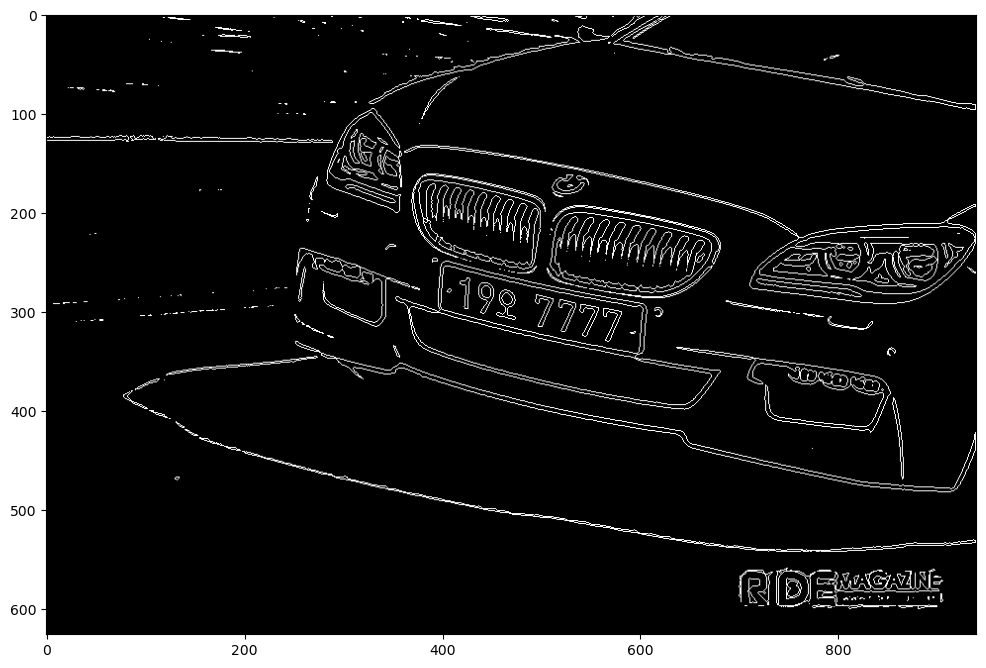

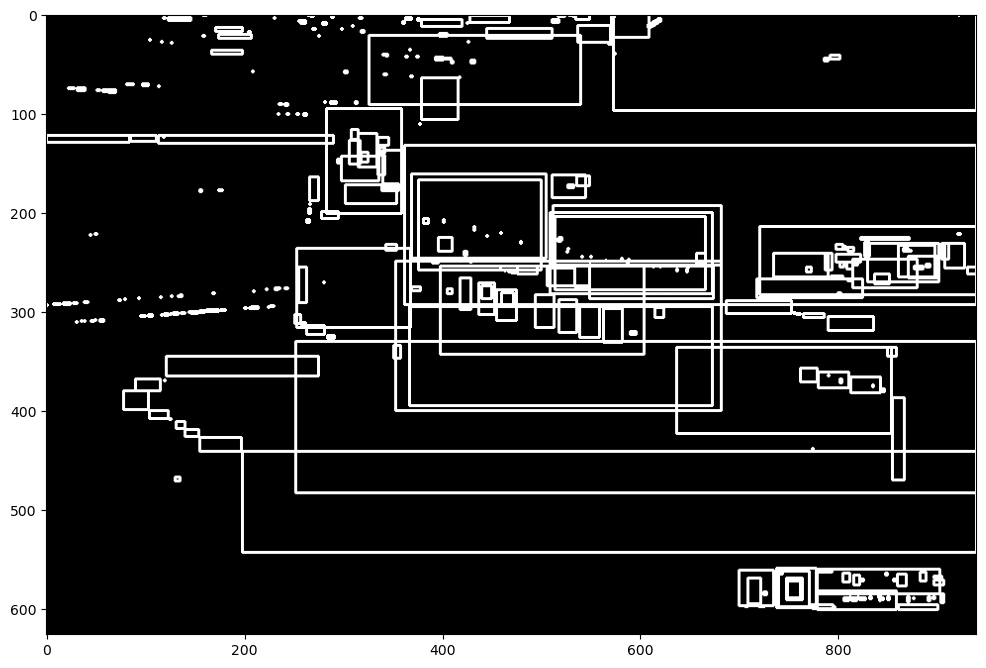

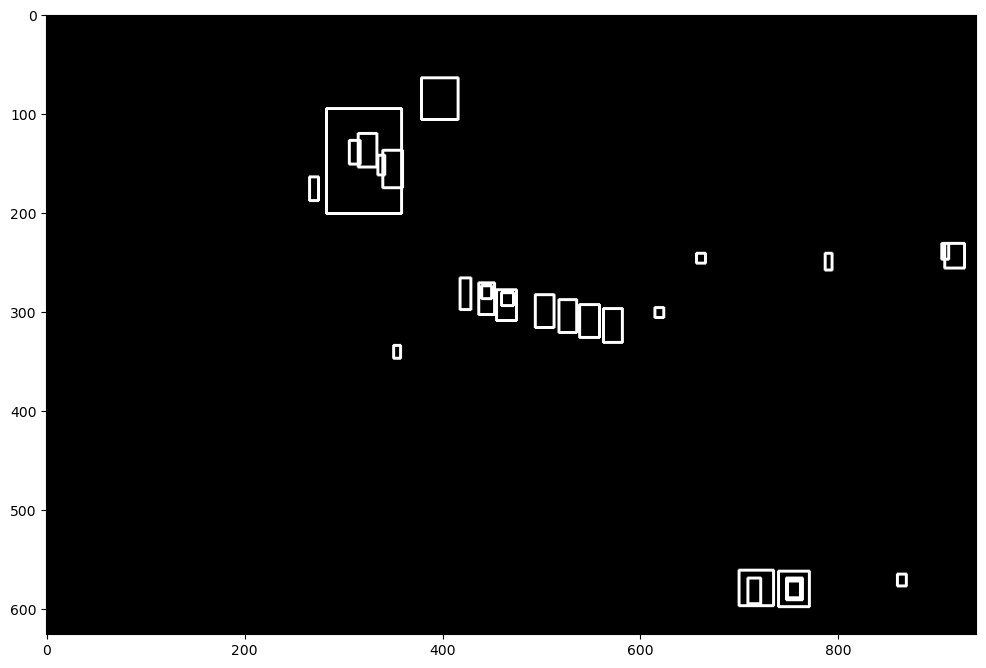

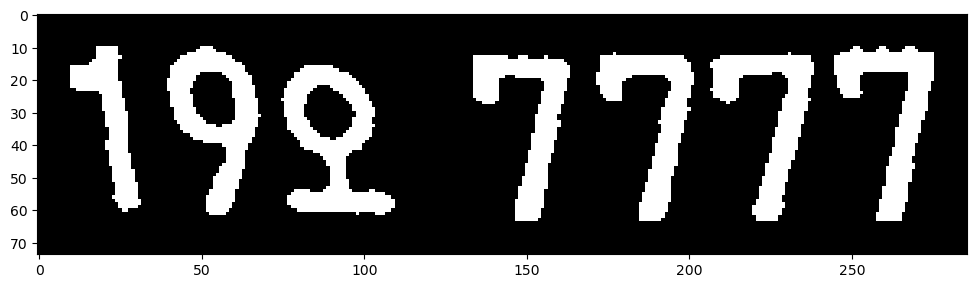

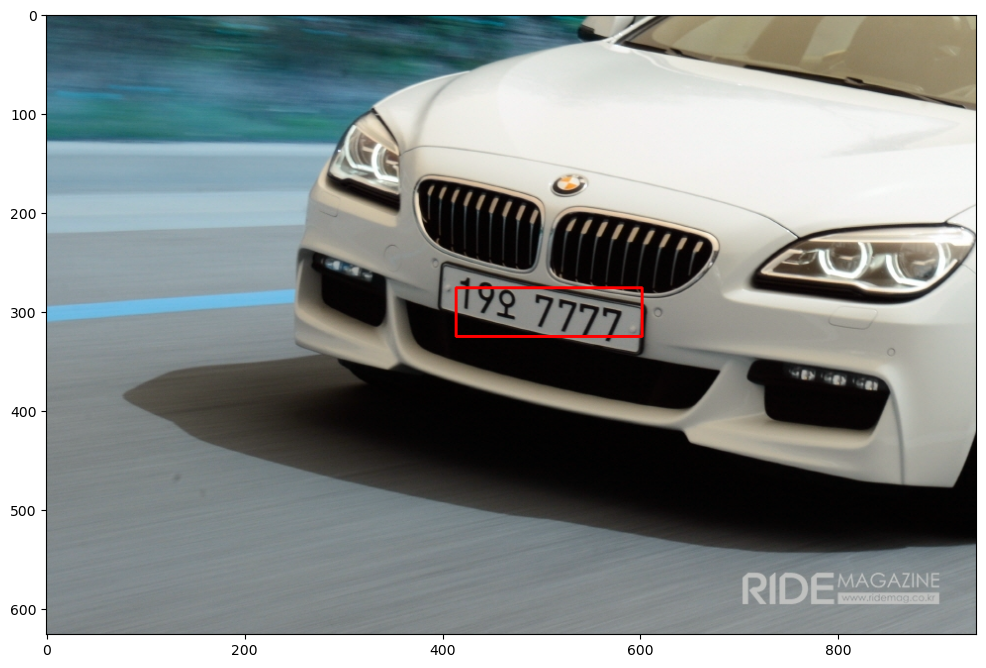

In [22]:
# gray scale로 변환
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# maximize contrast
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Adaptive Thresholding
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

#윤곽선 검출
import numpy as np

contours, _  = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

#데이터 준비
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

#문자 크기에 맞는 영역 선택
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 등고선 후보 선택
MAX_DIAG_MULTIPLYER = 5 # 5
MAX_ANGLE_DIFF = 12.0 # 12.0
MAX_AREA_DIFF = 0.5 # 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3 # 3

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # 등고선 추가
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
                
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# 등고선 출력
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')
# 이미지 회전
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

# 문자 판독을 위한 이진화
import pytesseract

longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
    pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
    
    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')
    
#결과 출력
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)

> 객체인식

In [37]:
import cv2
img = cv2.imread("c:/vscode/data/images/image.jpg")
img=cv2.resize(img, (640, 480))
img_object = cv2.imread("c:/vscode/data/images/object.jpg", cv2.IMREAD_GRAYSCALE)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=40000)
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(img_object, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
count = 100
for i in matches[:count]:
    idx = i.queryIdx
    x1, y1 = kp1[idx].pt
    cv2.circle(img, (int(x1), int(y1)), 3, (0, 0, 255), 3)
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

> 특징점 매칭

In [39]:
import cv2
img = cv2.imread("c:/vscode/data/images/image.jpg")
img=cv2.resize(img, (640, 480))
img_object = cv2.imread("c:/vscode/data/images/object.jpg", cv2.IMREAD_GRAYSCALE)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
orb = cv2.ORB_create(nfeatures=40000)
kp1, des1 = orb.detectAndCompute(gray, None)
kp2, des2 = orb.detectAndCompute(img_object, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)
count = 100
for i in matches[:count]:
    idx = i.queryIdx
    x1, y1 = kp1[idx].pt
    cv2.circle(img, (int(x1), int(y1)), 3, (0, 0, 255), 3)
flag = (cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS |
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
matching_result = cv2.drawMatches(img, kp1, img_object, kp2,
                            matches[:count], None, flags=flag)
cv2.imshow("Matching result", matching_result)
cv2.waitKey(0)
cv2.destroyAllWindows()

> 얼굴 인식

In [23]:
import matplotlib.pyplot as plt
import cv2

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
            for i in range(len(img)):
                titles.append(title)
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [24]:
cascades_path = cv2.data.haarcascades
detectorPaths = {
    "face": "haarcascade_frontalface_default.xml",
    "eyes": "haarcascade_eye.xml",
}

In [25]:
import os
detectors = {}
for (name, path) in detectorPaths.items():
    path = os.path.sep.join([cascades_path, path])
    detectors[name] = cv2.CascadeClassifier(path)

In [29]:
import imutils
image_path = 'c:/vscode/data/images/general.jpg'
image = cv2.imread(image_path)
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [30]:
faceRects = detectors["face"].detectMultiScale(gray,
        scaleFactor=1.03, minNeighbors=5, minSize=(40, 40),
        flags=cv2.CASCADE_SCALE_IMAGE)

In [31]:
for (fX, fY, fW, fH) in faceRects:
    # 얼굴 ROI 추출
    faceROI = gray[fY:fY+ fH, fX:fX + fW]
    # 눈 ROI 추출
    eyeRects = detectors["eyes"].detectMultiScale(faceROI,
            scaleFactor=1.3, minNeighbors=3, minSize=(3, 3),
            flags=cv2.CASCADE_SCALE_IMAGE)
    for (eX, eY, eW, eH) in eyeRects:
        ptA = (fX + eX, fY + eY)
        ptB = (fX + eX + eW, fY + eY + eH)
        # eye box
        cv2.rectangle(image, ptA, ptB, (0, 0, 255), 2)
    # face box
    cv2.rectangle(image, (fX, fY), (fX + fW, fY + fH), (0, 255, 0), 5)

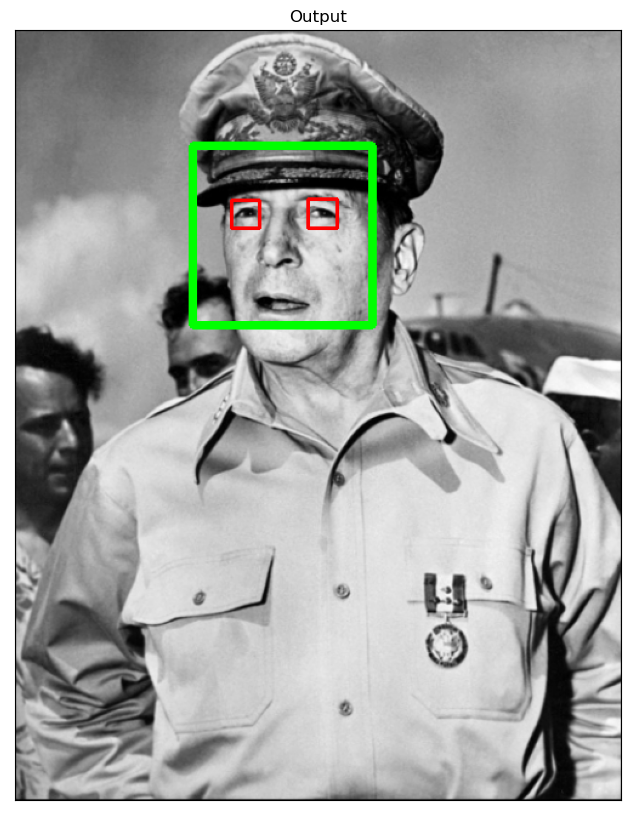

In [32]:
plt_imshow("Output", image, figsize=(16,10))

> 동영상 베경제거

In [41]:
import cv2 as cv
# 백그라운드 감산기 객체 생성
backSub = cv.createBackgroundSubtractorMOG2()
capture = cv.VideoCapture('c:/vscode/data/video/vtest.avi')
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
while True:
    ret, frame = capture.read()
    if frame is None:
        break
    #배경이 추출된 영상
    fgMask = backSub.apply(frame)
    #배경에서 추출된 영상을 오프닝한 영상
    fgMask_morph = cv.morphologyEx(fgMask, cv.MORPH_OPEN, kernel)
    cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
                cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    cv.imshow('Frame', frame)
    cv.imshow('FG Mask Blur', fgMask_morph)
    keyboard = cv.waitKey(1) & 0xFF
    if keyboard == 27:
        break
capture.release()
cv.destroyAllWindows()

> 동영상 객체검출

In [45]:
import cv2
import numpy as np
import tensorflow as tf
model = tf.saved_model.load("c:/vscode/data/model/ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model")
capture = cv2.VideoCapture("c:/vscode/data/video/bird.mp4")
while True:
    ret, frame = capture.read()
    frame=cv2.resize(frame, (640, 480))
    if capture.get(cv2.CAP_PROP_POS_FRAMES) ==capture.get(cv2.CAP_PROP_FRAME_COUNT):
        break
    input_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    input_tensor = tf.convert_to_tensor(input_img)
    input_tensor = input_tensor[tf.newaxis, ...]
    output_dict = model.signatures["serving_default"](input_tensor)
    classes = output_dict["detection_classes"][0]
    scores = output_dict["detection_scores"][0]
    boxes = output_dict["detection_boxes"][0]
    height, width, _ = frame.shape
    for idx, score in enumerate(scores):
        if score > 0.7:
            class_id = int(classes[idx])
            box = boxes[idx]
            x1 = int(box[1] * width)
            y1 = int(box[0] * height)
            x2 = int(box[3] * width)
            y2 = int(box[2] * height)
            cv2.rectangle(frame, (x1, y1), (x2, y2), 255, 1)
            cv2.putText(frame, str(class_id) + ":" + str(float(score)),
            (x1, y1 - 5), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 255, 255), 1)
    cv2.imshow("Object Detection", frame)
    if cv2.waitKey(33) == ord("q"):
        break
cv2.destroyAllWindows()

> 동영상 추적

In [48]:
import cv2
import numpy as np
cap = cv2.VideoCapture("c:/vscode/data/video/vtest.avi")
fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold=100)
while True:
    ret, frame = cap.read()
    if frame is None:
        break
    frame = cv2.resize(frame, (800, 600))
    fgmask = fgbg.apply(frame)
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(fgmask)
    for index, centroid in enumerate(centroids):
        if stats[index][0] == 0 and stats[index][1] == 0:
            continue
        if np.any(np.isnan(centroid)):
            continue
        x, y, width, height, area = stats[index]
        centerX, centerY = int(centroid[0]), int(centroid[1])
        if area > 300:
            cv2.circle(frame, (centerX, centerY), 1, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x + width, y + height), (0, 0,255))
            cv2.putText(frame, str(nlabels), (x, y), cv2.FONT_HERSHEY_COMPLEX, 1.0, (0, 255, 255), 1)
    cv2.imshow('mask',fgmask)
    cv2.imshow('frame',frame)
    keyboard = cv2.waitKey(1) & 0xFF
    if keyboard == 27:
        break
cap.release()
cv2.destroyAllWindows()